# Análise da comparação entre as palavras das sentenças do CohQuAD In pt-br 

Realiza a análise da comparação entre  as palavras das sentenças dos documentos originais e perturbados dos dados  utilizando o arquivo:
- `comparacao_palavra_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 

# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documentoLimpo = re.compile("<.*?>")
    return re.sub(documentoLimpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [12]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [16]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [17]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [18]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [19]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.9 MB/s 
     |████████████████████████████████| 162 kB 43.6 MB/s 
     |████████████████████████████████| 181 kB 41.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 158 kB 43.9 MB/s 
     |████████████████████████████████| 157 kB 45.7 MB/s 
     |████████████████████████████████| 157 kB 42.1 MB/s 
     |████████████████████████████████| 157 kB 69.4 MB/s 
     |████████████████████████████████| 157 kB 69.4 MB/s 
     |████████████████████████████████| 157 kB 61.8 MB/s 
     |████████████████████████████████| 157 kB 68.9 MB/s 
     |████████████████████████████████| 157 kB 52.4 MB/s 
     |████████████████████████████████| 156 kB 58.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cc50be3fa2a1d912c6989497d6f1fe1d00708af4894dda92726c32f29fa5

# 2 Parametrização

## Gerais

In [20]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 100

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 100

## Específicos

Parâmetros do modelo

In [21]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    
    #pretrained_model_name_or_path = "bert-large-cased",
    #pretrained_model_name_or_path = "bert-base-cased"
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    #modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = True,
    do_lower_case = False,   # default True  
    output_attentions = False,    # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [22]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_IN_PTBR"

## Define o caminho para os arquivos de dados

In [23]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [24]:
# Import de bibliotecas
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação das palavras



## 3.1 Carregamento dos arquivos de dados originais e perturbados

### 3.1.1 Especifica os nomes dos arquivos de dados



In [25]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [26]:
# Import de bibliotecas
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_IN_PTBR


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [27]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [28]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [29]:
# Import de bibliotecas
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [30]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
4,5p0,['Como empilhar elementos em uma estrutura de ...,Como empilhar elementos em uma estrutura de da...
7,8p0,['Como desempilhar elementos em uma estrutura ...,Como desempilhar elementos em uma estrutura de...
14,15p0,['O que é uma fila e como empilhar e desempilh...,O que é uma fila e como empilhar e desempilhar...
9,10p0,['O que é uma pilha e como enfileirar seu elem...,O que é uma pilha e como enfileirar seu elemento?
16,17p0,['Como são implementadas as operações de empil...,Como são implementadas as operações de empilha...


In [31]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
0,1p0,"[[['Como', 'enfileirar', 'elementos', 'em', 'u..."
18,19p0,"[[['Em', 'uma', 'pilha', 'a', 'operação', 'de'..."
11,12p0,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
13,14p0,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
10,11p0,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [32]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [33]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
1p0,[Como enfileirar elementos em uma pilha?],Como enfileirar elementos em uma pilha?
2p0,[Como desenfileirar elementos em uma pilha?],Como desenfileirar elementos em uma pilha?
3p0,[Como empilhar elementos em uma fila?],Como empilhar elementos em uma fila?
4p0,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma f...
5p0,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...


In [34]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
1p0,"[[[Como, enfileirar, elementos, em, uma, pilha..."
2p0,"[[[Como, desenfileirar, elementos, em, uma, pi..."
3p0,"[[[Como, empilhar, elementos, em, uma, fila, ?..."
4p0,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5p0,"[[[Como, empilhar, elementos, em, uma, estrutu..."


#### Carrega o arquivo dos dados perturbados e POS

In [35]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 2000.
INFO:root:TERMINADO PERTURBADOS POS: 2000.


AlgUns csv estão com os nomes das colunas errados

In [36]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [37]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
288,3p0_pert_88,['Como transformar elementos em uma fila ?'],Como transformar elementos em uma fila ?,"[['Como [MASK] elementos em uma fila ?', 'empi..."
1159,12p0_pert_59,['O que é uma fila e como entra um elemento ne...,O que é uma fila e como entra um elemento nela ?,[['O que é uma fila e como [MASK] um elemento ...
1785,18p0_pert_85,['Como são realmente as operações de enfileira...,Como são realmente as operações de enfileirar ...,[['Como são [MASK] as operações de enfileirar ...
1671,17p0_pert_71,['Como são implementadas as operações de empil...,Como são implementadas as operações de empilha...,[['Como são implementadas as operações de empi...
1913,20p0_pert_13,['Em uma fila a operação de adição ocorre em q...,Em uma fila a operação de adição ocorre em qua...,[['Em uma fila a operação de [MASK] ocorre em ...


In [38]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
216,3p0_pert_16,"[[['Como', 'escolher', 'elementos', 'em', 'uma..."
763,8p0_pert_63,"[[['Como', 'desempilhar', 'elementos', 'em', '..."
7,1p0_pert_7,"[[['Como', 'separar', 'elementos', 'em', 'uma'..."
556,6p0_pert_56,"[[['Como', 'expor', 'e', 'desempilhar', 'eleme..."
1687,17p0_pert_87,"[[['Como', 'são', 'implementadas', 'as', 'oper..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [39]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 2000.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 2000.


#### Criando dados indexados perturbados

In [40]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
1p0_pert_0,[Como colocar elementos em uma pilha ?],Como colocar elementos em uma pilha ?,"[[Como [MASK] elementos em uma pilha ?, enfile..."
1p0_pert_1,[Como adicionar elementos em uma pilha ?],Como adicionar elementos em uma pilha ?,"[[Como [MASK] elementos em uma pilha ?, enfile..."
1p0_pert_2,[Como organizar elementos em uma pilha ?],Como organizar elementos em uma pilha ?,"[[Como [MASK] elementos em uma pilha ?, enfile..."
1p0_pert_3,[Como identificar elementos em uma pilha ?],Como identificar elementos em uma pilha ?,"[[Como [MASK] elementos em uma pilha ?, enfile..."
1p0_pert_4,[Como encontrar elementos em uma pilha ?],Como encontrar elementos em uma pilha ?,"[[Como [MASK] elementos em uma pilha ?, enfile..."


In [41]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
1p0_pert_0,"[[[Como, colocar, elementos, em, uma, pilha, ?..."
1p0_pert_1,"[[[Como, adicionar, elementos, em, uma, pilha,..."
1p0_pert_2,"[[[Como, organizar, elementos, em, uma, pilha,..."
1p0_pert_3,"[[[Como, identificar, elementos, em, uma, pilh..."
1p0_pert_4,"[[[Como, encontrar, elementos, em, uma, pilha,..."


### 5.1.5 Agrupar os dados originais e perturbados

In [42]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [43]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 2020.


In [44]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 2020.


In [45]:
lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
1915,19p0_pert_96,[Em uma pilha a operação de enfileirar requer ...,Em uma pilha a operação de enfileirar requer e...,0
805,8p0_pert_97,[Como desempilhar elementos em uma estrutura d...,Como desempilhar elementos em uma estrutura de...,0
988,10p0_pert_78,[O que é uma pilha e como interpretar seu elem...,O que é uma pilha e como interpretar seu eleme...,0
483,5p0_pert_78,[Como estabelecer elementos em uma estrutura d...,Como estabelecer elementos em uma estrutura de...,0
1816,18p0_pert_98,[Como são fazer as operações de enfileirar e d...,Como são fazer as operações de enfileirar e de...,0


In [46]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 2020.


In [47]:
lista_documentos_agrupados_pos.sample(5)

,id,pos_documento
952,10p0_pert_52,"[[[O, que, é, uma, pilha, e, como, contar, seu..."
601,7p0_pert_1,"[[[Como, desempilhar, elementos, em, uma, pint..."
77,1p0_pert_77,"[[[Como, nomear, elementos, em, uma, pilha, ?]..."
218,3p0_pert_18,"[[[Como, reunir, elementos, em, uma, fila, ?],..."
1398,14p0_pert_98,"[[[O, que, é, uma, fila, e, como, vem, um, ele..."


#### Criar dados indexados

In [48]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
1p0,[Como enfileirar elementos em uma pilha?],Como enfileirar elementos em uma pilha?,1
1p0_pert_0,[Como colocar elementos em uma pilha ?],Como colocar elementos em uma pilha ?,0
1p0_pert_1,[Como adicionar elementos em uma pilha ?],Como adicionar elementos em uma pilha ?,0
1p0_pert_2,[Como organizar elementos em uma pilha ?],Como organizar elementos em uma pilha ?,0
1p0_pert_3,[Como identificar elementos em uma pilha ?],Como identificar elementos em uma pilha ?,0


In [49]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

,pos_documento
id,
1p0,"[[[Como, enfileirar, elementos, em, uma, pilha..."
2p0,"[[[Como, desenfileirar, elementos, em, uma, pi..."
3p0,"[[[Como, empilhar, elementos, em, uma, fila, ?..."
4p0,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5p0,"[[[Como, empilhar, elementos, em, uma, estrutu..."


## 3.2 Carregamento do arquivo de dado comparação 

### 3.2.1 Especifica os nomes dos arquivos de dados



In [50]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_COMPACTADO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [51]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/COHQUAD_IN_PTBR


In [52]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [53]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

INFO:root:Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [54]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_palavra = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_palavra)))

INFO:root:TERMINADO ORIGINAIS: 113120.


In [55]:
lista_comparacao_palavra.sample(5)

,id,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
86857,17p0_pert_58,1675,0,9,elementos,NOUN,11,uma,DET,0.603376,36.125050,1722.2568,0.603376,36.125050,1722.2568
73342,15p0_pert_97,1512,0,4,fila,NOUN,11,elementos,NOUN,0.608497,36.920071,1706.9856,0.562871,39.660252,1847.3962
34624,10p0_pert_20,930,0,4,pilha,NOUN,9,elemento,NOUN,0.671274,33.737289,1571.4962,0.671274,33.737289,1571.4962
92854,18p0_pert_23,1741,0,7,e,CCONJ,11,uma,DET,0.161576,42.688309,1707.8620,0.161576,42.688309,1707.8620
105652,19p0_pert_87,1906,0,7,parou,VERB,8,em,ADP,0.727248,36.656841,1706.1664,0.727248,36.656841,1706.1664


### 3.5.5 Criando dados indexados

In [56]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id", "index_sentenca", "index_wi", "index_wj"])
lista_comparacao_palavra_indexado.head()

index_documento    wi  pos_i  \
id  index_sentenca index_wi index_wj                                 
1p0 0              0        1                       0  Como  SCONJ   
                            2                       0  Como  SCONJ   
                            3                       0  Como  SCONJ   
                            4                       0  Como  SCONJ   
                            5                       0  Como  SCONJ   

                                              wj pos_j  cos_mean   euc_mean  \
id  index_sentenca index_wi index_wj                                          
1p0 0              0        1         enfileirar  VERB  0.761694  25.747267   
                            2          elementos  NOUN  0.617482  35.318653   
                            3                 em   ADP  0.650087  33.424171   
                            4                uma   DET  0.704987  29.126415   
                            5              pilha  NOUN  0.603006  34.711918   

                                       man_mean   cos_max    euc_max  \
id  index_sentenca index_wi index_wj                                   
1p0 0              0        1         1281.7346  0.663389  32.028095   
                            2         1718.4980  0.617482  35.318653   
                            3         1681.7717  0.650087  33.424171   
                            4         1443.1240  0.704987  29.126415   
                            5         1627.4218  0.603006  34.711918   

                                        man_max  
id  index_sentenca index_wi index_wj             
1p0 0              0        1         1584.6208  
                            2         1718.4980  
                            3         1681.7717  
                            4         1443.1240  
                            5         1627.4218

## 3.3 Estatísticas

### Estatísticas das medidas dos pares de palavras

In [57]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_palavra[["cos_mean", "euc_mean", "man_mean", "cos_max", "euc_max", "man_max" ]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,113120.000000,113120.000000,113120.000000,113120.000000,113120.000000,113120.000000
mean,0.633905,33.715206,1614.663405,0.617141,34.834126,1670.368472
std,0.111666,5.041517,207.151986,0.114674,5.195833,219.353879
min,0.066207,14.579185,695.769400,0.066207,16.533779,825.288100
25%,0.586498,30.571531,1483.302500,0.563052,31.639978,1541.374000
50%,0.642900,33.405199,1624.030050,0.623744,34.960707,1687.440050
75%,0.699162,36.936570,1754.387950,0.683975,38.274005,1822.321600
max,0.912368,62.703007,2326.535600,0.906311,62.703007,2423.937000


### Estatísticas das maiores discrepâncias por documento

In [58]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

discrepancias  = lista_comparacao_palavra.groupby("id").agg({"cos_mean":[coluna_discrepancia_cos], 
                                                             "euc_mean":[coluna_discrepancia_euc], 
                                                             "man_mean":[coluna_discrepancia_man],
                                                             "cos_max":[coluna_discrepancia_cos], 
                                                             "euc_max":[coluna_discrepancia_euc], 
                                                             "man_max":[coluna_discrepancia_man],
                                                             })

In [59]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
,min,max,max,min,max,max
count,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000
mean,0.463683,42.845740,1957.286926,0.449224,43.433113,2010.870285
std,0.141987,5.111794,154.509695,0.137498,4.823050,162.046890
min,0.066207,31.530664,1551.332500,0.066207,34.031891,1627.807600
25%,0.437318,38.572072,1820.090500,0.428917,39.757872,1891.250725
50%,0.481688,43.139948,1986.785050,0.470787,43.628382,2046.392050
75%,0.569191,46.210403,2084.094525,0.537028,46.409713,2125.397975
max,0.662388,62.703007,2326.535600,0.629381,62.703007,2423.937000


### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [60]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [61]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])

1 ? 2021
2 uma 2020
3 e 1415
4 elementos 1212
5 em 1212
6 fila 1012
7 Como 1010
8 é 814
9 O 808
10 que 808
11 como 808
12 pilha 710
13 de 708
14 elemento 606
15 desempilhar 507
16 um 404
17 nela 404
18 estrutura 305
19 dados 305
20 desenfileirar 304


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### COS

In [62]:
medida = "cos"

#### MEAN

In [63]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [64]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADJ,279.000000,0.582264,0.130126,0.082179,0.576146,0.609344,0.641178,0.747799
ADP,9887.000000,0.683663,0.067602,0.119914,0.632592,0.681390,0.729286,0.861093
ADV,8164.000000,0.641078,0.111182,0.067858,0.583714,0.651702,0.706445,0.840617
AUX,9837.000000,0.614414,0.103751,0.066451,0.570643,0.628232,0.677104,0.852109
CCONJ,8391.000000,0.582426,0.209680,0.071491,0.544383,0.636337,0.724149,0.906311
DET,17977.000000,0.659822,0.087668,0.077015,0.621592,0.659833,0.708815,0.887216
NOUN,22518.000000,0.635476,0.076543,0.089198,0.591476,0.638581,0.685708,0.878527
NUM,1.000000,0.619095,NaN,0.619095,0.619095,0.619095,0.619095,0.619095
PRON,17469.000000,0.610560,0.117612,0.066207,0.518367,0.595751,0.709749,0.843717


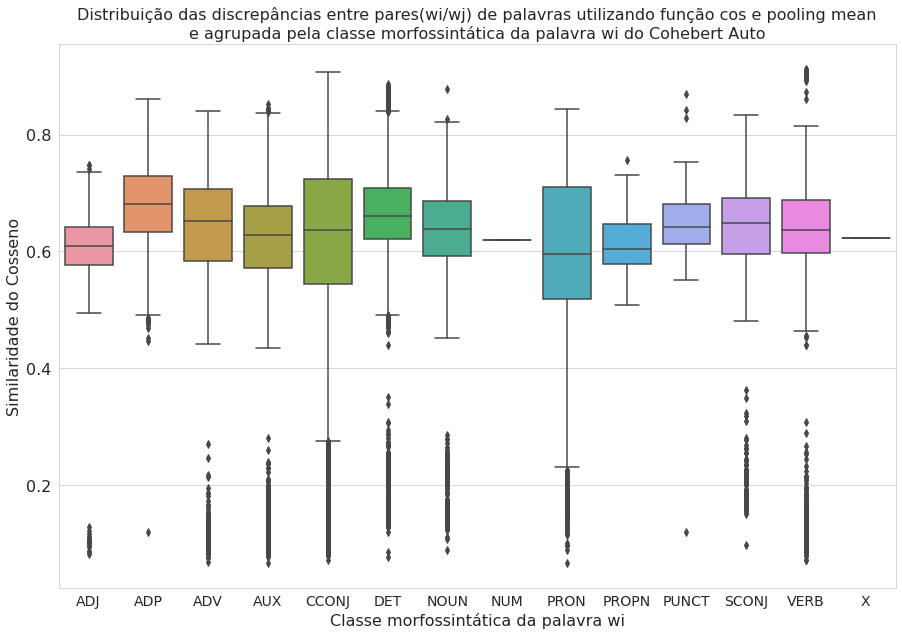

In [65]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [66]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADJ,661.000000,0.651315,0.042649,0.446050,0.621369,0.651639,0.683245,0.761011
ADP,9047.000000,0.665540,0.101611,0.071491,0.628450,0.675712,0.718971,0.861093
ADV,5915.000000,0.661528,0.088258,0.150619,0.625377,0.668335,0.716192,0.901491
AUX,2046.000000,0.729986,0.049113,0.450941,0.705374,0.734021,0.763731,0.844489
CCONJ,7488.000000,0.556802,0.219917,0.066207,0.543164,0.630820,0.691080,0.906311
DET,18879.000000,0.649510,0.100593,0.110942,0.601112,0.651257,0.704186,0.912368
NOUN,31811.000000,0.620783,0.097655,0.078279,0.561907,0.629484,0.694448,0.878527
NUM,8.000000,0.619816,0.027551,0.585840,0.599044,0.619043,0.627688,0.670261
PRON,5237.000000,0.616614,0.092916,0.143931,0.551696,0.623353,0.675635,0.799122


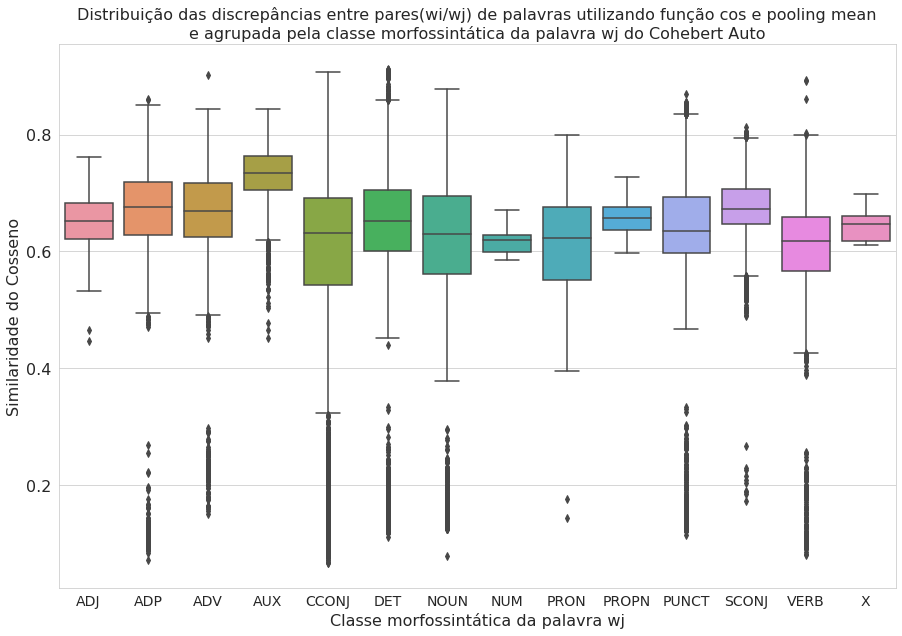

In [67]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

#### MAX

In [68]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [69]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADJ,279.000000,0.566655,0.136895,0.082179,0.551793,0.607229,0.641178,0.747799
ADP,9887.000000,0.674883,0.068590,0.119914,0.624024,0.671717,0.715192,0.861093
ADV,8164.000000,0.619134,0.115450,0.067858,0.559416,0.614926,0.683779,0.840617
AUX,9837.000000,0.605277,0.108385,0.066451,0.541118,0.625074,0.676928,0.852109
CCONJ,8391.000000,0.570330,0.208570,0.070427,0.538824,0.614512,0.716228,0.906311
DET,17977.000000,0.646666,0.093831,0.077015,0.605006,0.653426,0.696075,0.887216
NOUN,22518.000000,0.608287,0.078164,0.089198,0.563138,0.604736,0.658337,0.878527
NUM,1.000000,0.619095,NaN,0.619095,0.619095,0.619095,0.619095,0.619095
PRON,17469.000000,0.605792,0.121479,0.066207,0.509148,0.593325,0.709749,0.843717


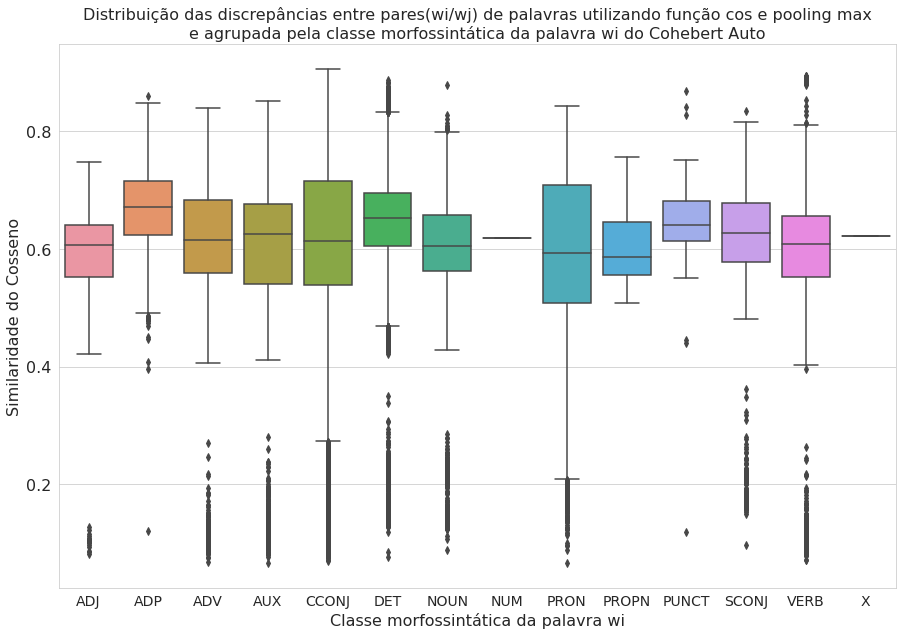

In [70]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [71]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADJ,661.000000,0.637000,0.055316,0.446050,0.606200,0.638394,0.680611,0.761011
ADP,9047.000000,0.648590,0.104147,0.071491,0.605424,0.654498,0.706934,0.861093
ADV,5915.000000,0.627476,0.106414,0.097815,0.553530,0.646333,0.693950,0.888144
AUX,2046.000000,0.728976,0.052003,0.450941,0.705374,0.734021,0.763731,0.844489
CCONJ,7488.000000,0.552585,0.221648,0.066207,0.533141,0.629734,0.690048,0.906311
DET,18879.000000,0.635584,0.107808,0.070427,0.583453,0.639364,0.695527,0.894621
NOUN,31811.000000,0.598484,0.096155,0.078279,0.539602,0.600560,0.672185,0.878527
NUM,8.000000,0.605356,0.049103,0.504762,0.594267,0.608671,0.627688,0.670261
PRON,5237.000000,0.610632,0.092489,0.143931,0.548805,0.612232,0.664995,0.799122


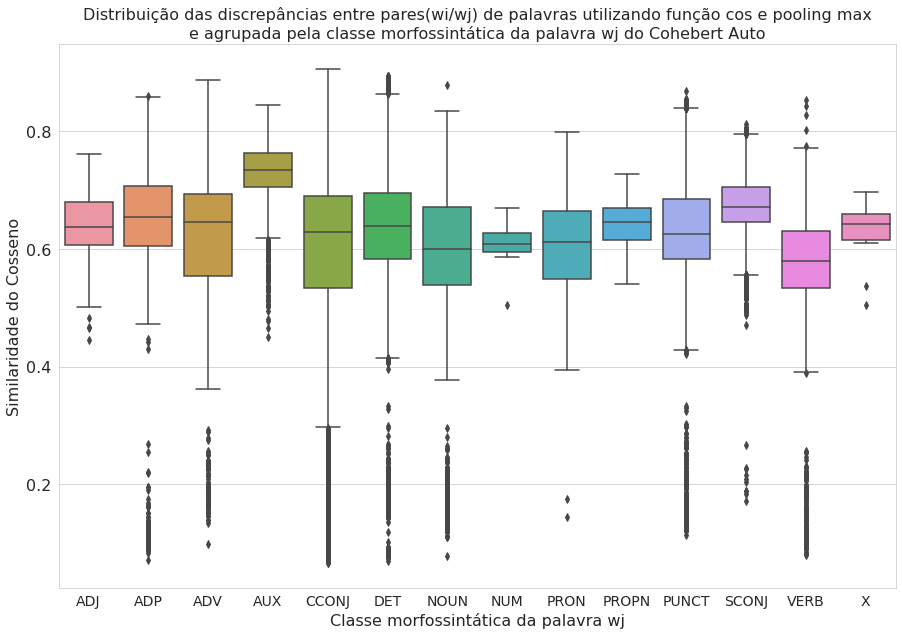

In [72]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

### EUC

In [73]:
medida = "euc"

#### MEAN

In [74]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [75]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADJ,279.000000,38.660027,4.412353,30.909447,35.699568,37.960453,40.501089,56.924419
ADP,9887.000000,31.806172,4.047943,21.813133,29.253543,31.837660,34.521406,54.883862
ADV,8164.000000,33.258314,5.112176,21.356033,29.589574,32.748333,37.242955,54.978188
AUX,9837.000000,34.416481,4.598612,21.101046,31.354826,33.579803,37.749176,53.289154
CCONJ,8391.000000,33.849108,7.067085,16.533779,28.534457,33.101582,39.309429,62.205524
DET,17977.000000,32.189384,4.495129,18.423031,29.564493,32.108112,34.212212,56.093693
NOUN,22518.000000,34.258532,3.610964,21.830118,31.886878,34.086634,36.653664,59.285793
NUM,1.000000,36.452866,NaN,36.452866,36.452866,36.452866,36.452866,36.452866
PRON,17469.000000,34.569329,6.210496,21.744478,29.544821,35.015450,39.048328,56.586987


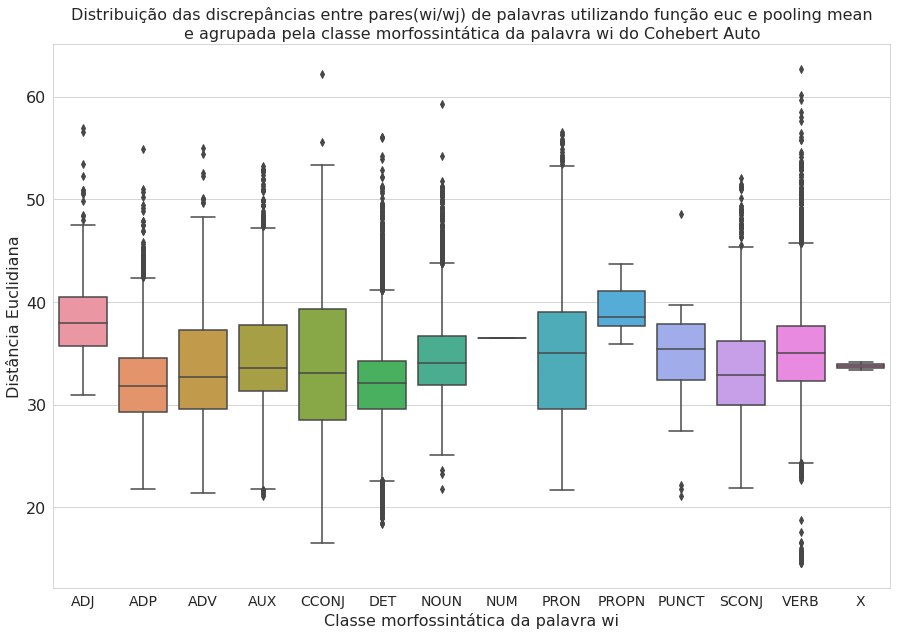

In [76]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [77]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADJ,661.000000,35.246806,2.819226,27.297356,33.266323,34.902302,36.847206,48.648632
ADP,9047.000000,32.756681,4.268759,20.724178,29.969582,32.684132,35.385141,51.956711
ADV,5915.000000,31.671039,3.681224,15.401643,28.846203,31.986353,33.653021,44.500084
AUX,2046.000000,28.953496,3.091706,21.832273,27.372959,28.606547,29.848924,46.498981
CCONJ,7488.000000,33.861117,6.212587,16.533779,30.169923,33.147877,37.704884,62.703007
DET,18879.000000,32.384690,4.618871,14.579185,29.554917,32.523403,35.352320,52.485058
NOUN,31811.000000,35.106635,4.783326,17.615896,31.590209,34.744152,38.603413,62.205524
NUM,8.000000,36.484114,1.225439,34.786385,35.553093,36.251850,37.670231,37.986279
PRON,5237.000000,35.461448,4.726831,24.818279,32.767483,35.934780,38.687473,48.234531


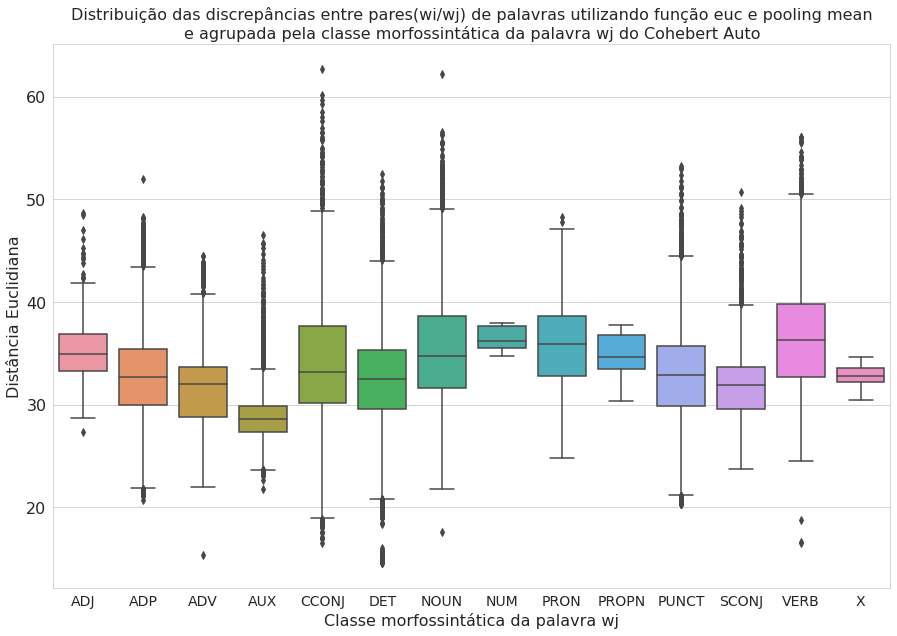

In [78]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAX

In [79]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [80]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADJ,279.000000,39.625882,5.053174,30.909447,35.951874,38.614681,42.922907,56.924419
ADP,9887.000000,32.355603,4.031929,21.813133,30.067360,32.530777,34.942932,54.883862
ADV,8164.000000,34.690803,5.322231,21.356033,31.160185,35.442434,38.782907,54.978188
AUX,9837.000000,35.049141,4.837284,21.101046,31.495277,34.331013,38.810921,53.289154
CCONJ,8391.000000,34.756828,7.107511,16.533779,29.345338,35.352844,39.686684,62.205524
DET,17977.000000,33.054598,4.772791,18.423031,30.314781,32.530529,35.884087,56.093693
NOUN,22518.000000,36.008814,3.352727,21.830118,33.845496,36.070799,37.960535,59.285793
NUM,1.000000,36.452866,NaN,36.452866,36.452866,36.452866,36.452866,36.452866
PRON,17469.000000,34.925023,6.417689,21.744478,29.546944,35.389648,39.959202,56.586987


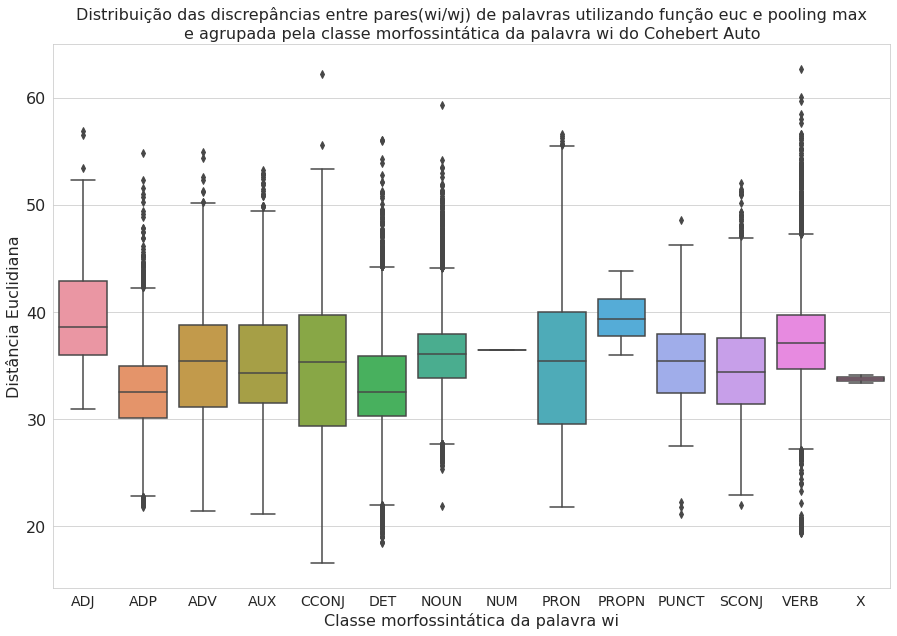

In [81]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [82]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADJ,661.000000,36.061188,3.310790,27.297356,33.622147,35.646484,37.975475,52.582924
ADP,9047.000000,33.817213,4.404693,20.724178,31.354834,33.850437,36.338699,51.956711
ADV,5915.000000,33.977728,5.052417,20.385046,31.105650,33.089626,37.893400,51.077579
AUX,2046.000000,29.011841,3.268505,21.832273,27.372959,28.606547,29.848924,49.577087
CCONJ,7488.000000,34.246133,6.461367,16.533779,30.217632,33.567619,37.849568,62.703007
DET,18879.000000,33.351623,5.037504,18.423031,30.320610,33.267071,36.453146,56.269615
NOUN,31811.000000,36.602235,4.441785,21.830118,33.386284,36.779106,39.551731,62.205524
NUM,8.000000,37.331243,2.338846,34.786385,35.863013,37.050728,37.952988,42.345726
PRON,5237.000000,35.820442,4.692091,24.818279,33.740017,36.382164,38.934608,48.234531


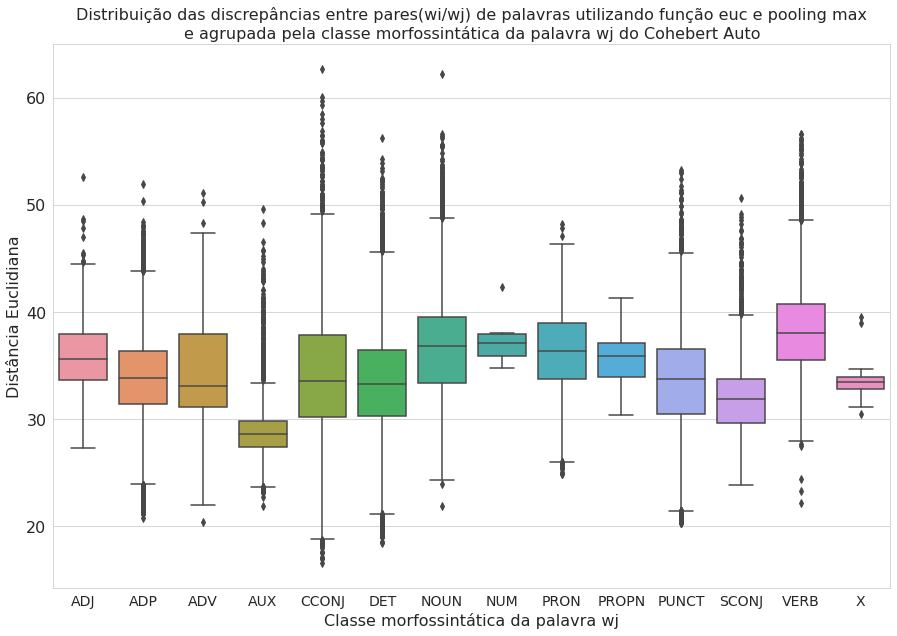

In [83]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

### MAN

In [84]:
medida = "man"

#### MEAN

In [85]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [86]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADJ,279.000000,1801.456259,139.445828,1475.834500,1690.138000,1791.407300,1906.287500,2150.057100
ADP,9887.000000,1541.957085,192.307558,1042.330800,1416.580950,1557.940800,1681.409450,2214.575200
ADV,8164.000000,1618.868837,216.675322,1057.279500,1472.870300,1627.497050,1779.287800,2198.167000
AUX,9837.000000,1642.090113,168.619236,1046.190800,1539.613500,1629.510000,1758.928000,2207.779800
CCONJ,8391.000000,1568.504204,238.511217,825.288100,1413.339950,1591.881200,1738.606000,2138.499000
DET,17977.000000,1553.269513,183.755146,922.516540,1438.771000,1574.023700,1665.560800,2141.269800
NOUN,22518.000000,1626.889771,148.924026,1095.268800,1517.153400,1627.813850,1735.099800,2176.960000
NUM,1.000000,1752.224000,NaN,1752.224000,1752.224000,1752.224000,1752.224000,1752.224000
PRON,17469.000000,1675.509130,273.145913,1055.910900,1447.570600,1723.513200,1887.707000,2326.535600


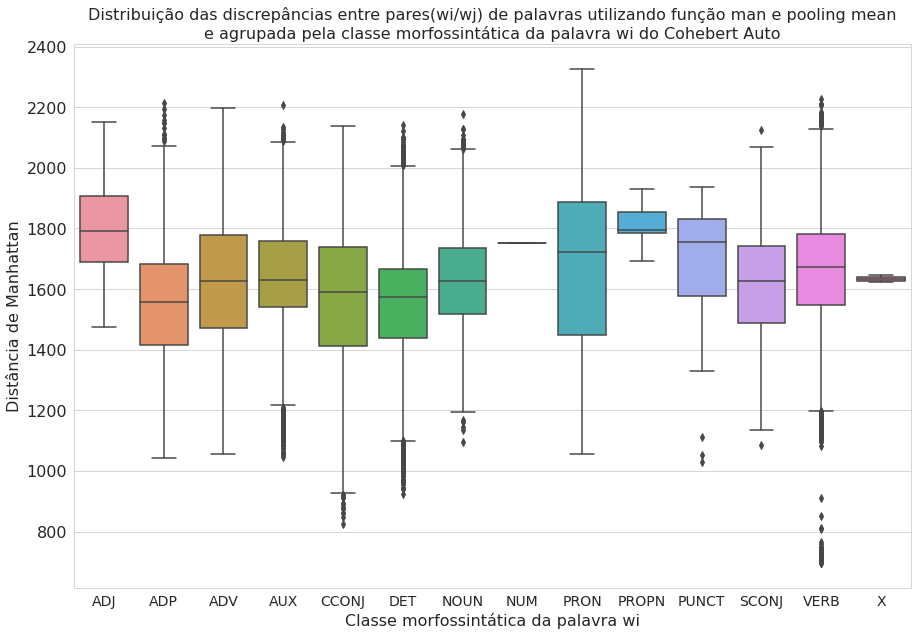

In [87]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [88]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADJ,661.000000,1636.470184,106.987936,1314.524700,1566.369600,1631.324000,1698.151700,2039.593800
ADP,9047.000000,1585.985857,173.127344,1043.523700,1462.340900,1597.723000,1712.720750,2211.243400
ADV,5915.000000,1544.335366,169.476123,737.115970,1413.444450,1570.452600,1653.007700,2025.590300
AUX,2046.000000,1416.243738,131.539927,1054.624000,1349.017675,1402.277500,1460.773275,2052.510700
CCONJ,7488.000000,1566.594222,190.843059,825.288100,1481.988200,1610.085550,1696.954600,2113.151400
DET,18879.000000,1574.947551,207.585995,695.769400,1454.428950,1598.063200,1707.348900,2226.034700
NOUN,31811.000000,1655.000603,202.551975,849.933960,1500.159600,1652.241700,1811.647400,2303.791500
NUM,8.000000,1739.965650,61.519881,1663.415400,1702.686075,1734.481200,1769.454400,1830.136500
PRON,5237.000000,1730.068877,218.143314,1232.254900,1599.397800,1747.472800,1891.252700,2222.956500


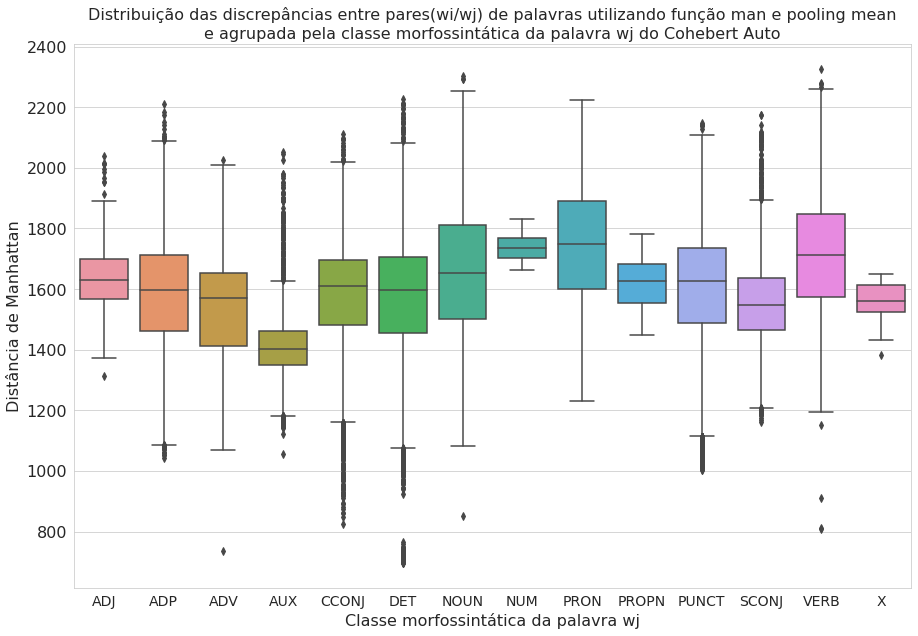

In [89]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

#### MAX

In [90]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [91]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADJ,279.000000,1847.107423,188.878524,1475.834500,1696.908300,1820.733800,1958.254400,2368.608200
ADP,9887.000000,1568.837919,192.630791,1042.330800,1446.691500,1589.513200,1708.282350,2423.937000
ADV,8164.000000,1690.049304,234.450823,1057.279500,1556.122350,1715.111700,1872.445675,2381.727300
AUX,9837.000000,1675.002024,188.692306,1046.190800,1546.123500,1657.523300,1814.025400,2334.181600
CCONJ,8391.000000,1619.124416,248.868229,825.288100,1458.438200,1666.247800,1813.081950,2138.499000
DET,17977.000000,1595.232303,203.004994,922.516540,1474.238500,1602.024700,1718.714600,2297.614300
NOUN,22518.000000,1713.790333,148.742326,1095.268800,1617.015150,1725.412850,1815.626925,2350.955600
NUM,1.000000,1752.224000,NaN,1752.224000,1752.224000,1752.224000,1752.224000,1752.224000
PRON,17469.000000,1693.831956,286.000704,1055.910900,1447.871200,1745.509500,1918.361600,2384.453600


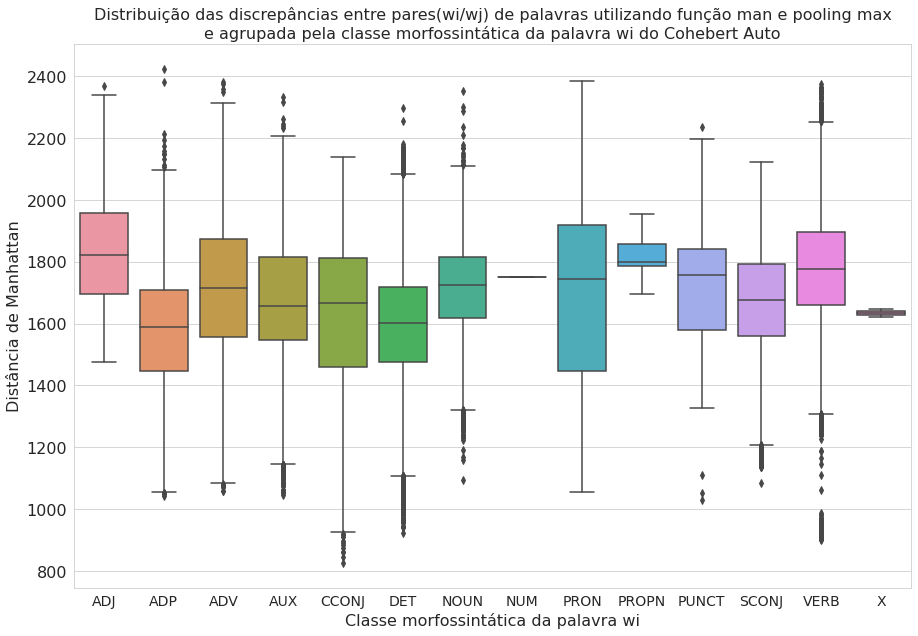

In [92]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [93]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADJ,661.000000,1673.911711,137.303191,1314.524700,1577.111900,1653.325300,1754.771600,2149.809300
ADP,9047.000000,1636.118062,184.165143,1043.523700,1533.678650,1652.537800,1752.819350,2269.890000
ADV,5915.000000,1663.607600,236.275448,949.523700,1527.723800,1645.160400,1844.403450,2336.226000
AUX,2046.000000,1419.034808,139.232832,1054.624000,1349.017675,1402.277500,1460.773275,2126.749500
CCONJ,7488.000000,1588.499868,203.677240,825.288100,1496.615000,1631.306300,1725.723700,2113.151400
DET,18879.000000,1622.726141,228.755371,901.257260,1494.381550,1635.780400,1760.862700,2423.937000
NOUN,31811.000000,1730.993614,194.453931,1095.268800,1590.483550,1747.385400,1870.386350,2311.165000
NUM,8.000000,1781.013225,121.538099,1663.415400,1711.000650,1748.375300,1823.278800,2041.781200
PRON,5237.000000,1746.308436,217.195077,1232.254900,1635.588100,1767.403200,1901.018600,2222.956500


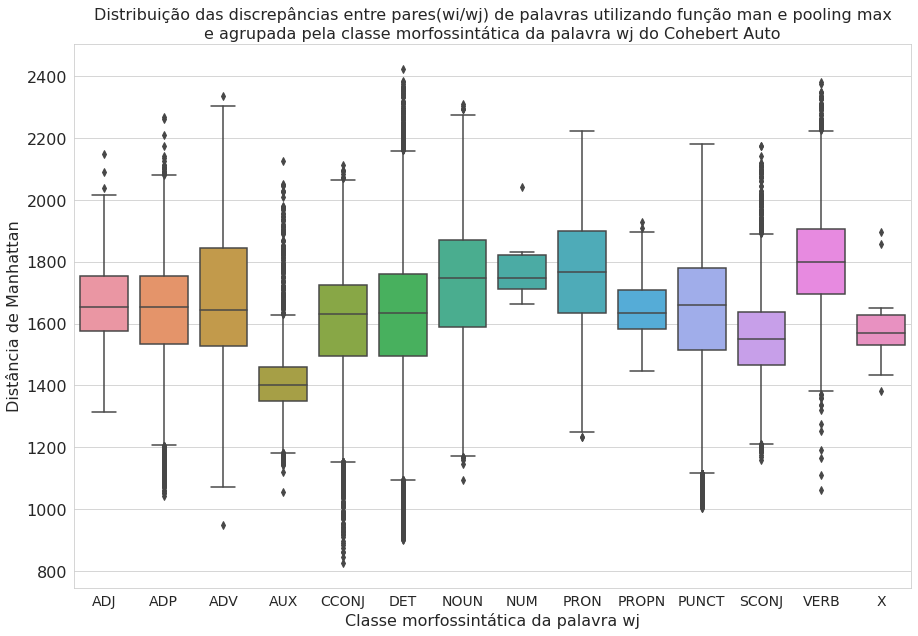

In [94]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias de determinados pares de palavras

### Geral

Conta pares de classes de palavras

In [95]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_palavra.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_palavra))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao["pos_i"]+"/"+linha_comparacao["pos_j"]] += 1

Documentos:   0%|          | 0/113120 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [96]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

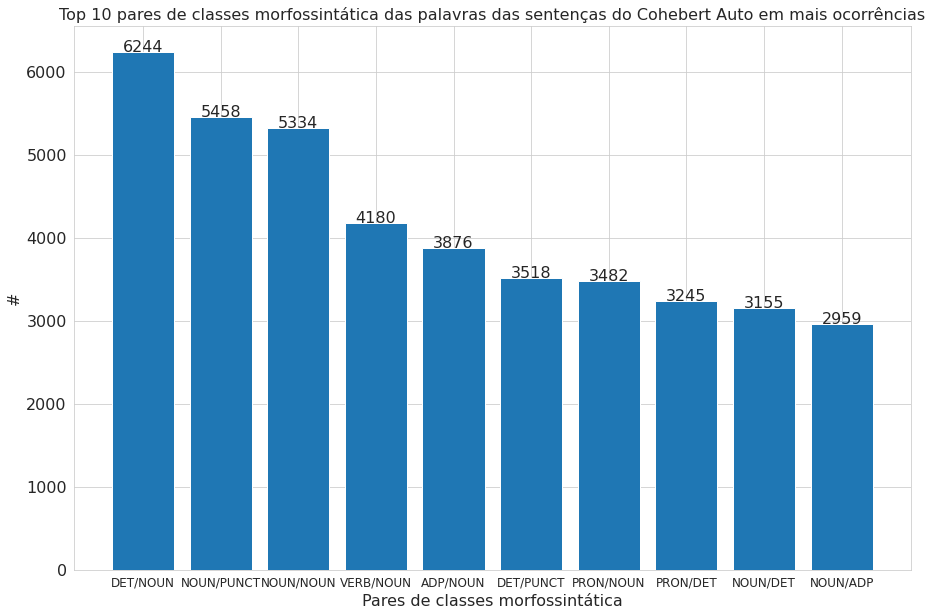

In [97]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do Cohebert Auto em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### VERB-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [98]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 557


Estatísticas das medidas dos pares de palavras

In [99]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000
mean,0.639342,35.338459,1639.554132,0.555627,40.865806,1897.912057
std,0.078721,5.605693,224.165686,0.073771,5.394990,197.518308
min,0.439100,16.538916,809.813400,0.395543,22.114347,1061.891500
25%,0.580986,31.624149,1481.414800,0.488514,36.097115,1722.433300
50%,0.632486,34.179043,1593.469700,0.574461,40.065674,1867.993300
75%,0.701071,39.886223,1822.128200,0.616492,44.684681,2073.002200
max,0.894137,50.514065,2157.011700,0.853132,56.666519,2348.854500


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [100]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/557 [00:00<?, ? documento/s]

In [101]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [102]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wi
      1 implementadas  199
      2      empilhar  100
      3    enfileirar   74
      4        fechar    3
      5         parar    3
      6        entrar    3
      7       separar    2
      8        juntar    2
      9        reunir    2
     10        cortar    2
     11         pegar    2
     12   identificar    2
     13        montar    2
     14         mover    2
     15   classificar    2
     16      carregar    2
     17      acomodar    2
     18      levantar    2
     19       prender    2
     20         colar    2


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [103]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/557 [00:00<?, ? documento/s]

In [104]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [105]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1 desempilhar  116
      2    empilhar  101
      3  enfileirar   67
      4      ocorre    9
      5   organizar    2
      6     colocar    2
      7  distribuir    2
      8     separar    2
      9      juntar    2
     10      reunir    2
     11       colar    2
     12   adicionar    2
     13      lançar    2
     14     dividir    2
     15    carregar    2
     16 classificar    2
     17        unir    2
     18       mover    2
     19  concentrar    2
     20    acomodar    2


#### COS

In [106]:
medida = "cos_mean"

Documentos outliers

In [107]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.12008494138717651
Limite superior             : 0.8811986148357391
Limite inferior             : 0.4008588492870331


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [108]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 557 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [109]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 557 ( 0.003590664272890485 )


In [110]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 557 ( 0.003590664272890485 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [111]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.8941372036933899 empilhar desempilhar
         Como empilhar e desempilhar elementos em uma fila? 1

 2 0.8910526633262634 empilhar desempilhar
         Como empilhar e desempilhar elementos em uma estrutura de dados fila? 1


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [112]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### EUC

In [113]:
medida = "euc_mean"

Documentos outliers

In [114]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 8.2620735168457
Limite superior             : 52.279333114624016
Limite inferior             : 19.231039047241218


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [115]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 557 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [116]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 557 ( 0.005385996409335727 )


In [117]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 557 ( 0.005385996409335727 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB


In [118]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB


In [119]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 16.538915634155273 empilhar desempilhar
         Como empilhar e desempilhar elementos em uma fila? 1

 2 16.654447555541992 empilhar desempilhar
         Como empilhar e desempilhar elementos em uma estrutura de dados fila? 1

 3 18.752582550048828 empilhar desempilhar
         Como são implementadas as operações de empilhar e desempilhar elementos em uma fila? 1


#### MAN

In [120]:
medida = "man_mean"

Documentos outliers

In [121]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 340.7134000000001
Limite superior             : 2333.1983
Limite inferior             : 970.3446999999999


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [122]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 557 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [123]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 557 ( 0.005385996409335727 )


In [124]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 557 ( 0.005385996409335727 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB

In [125]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_inferior) entre palavras da classe VERB

In [126]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 809.8134 empilhar desempilhar
         Como empilhar e desempilhar elementos em uma estrutura de dados fila? 1

 2 810.9693 empilhar desempilhar
         Como empilhar e desempilhar elementos em uma fila? 1

 3 910.4053 empilhar desempilhar
         Como são implementadas as operações de empilhar e desempilhar elementos em uma fila? 1


### NOUN-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [127]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5334


Estatísticas das medidas dos pares de palavras

In [128]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,5334.000000,5334.000000,5334.000000,5334.000000,5334.000000,5334.000000
mean,0.682033,32.651760,1535.045660,0.647480,34.926381,1653.536178
std,0.042478,3.083509,124.514397,0.063215,3.662771,164.759974
min,0.537399,21.830118,1095.268800,0.465812,21.830118,1095.268800
25%,0.656369,30.671366,1450.633600,0.604231,32.318423,1532.109500
50%,0.685356,32.384041,1528.178350,0.659475,34.724098,1663.448400
75%,0.712626,34.566113,1625.862850,0.696508,37.114342,1757.444450
max,0.878527,50.884773,2087.149200,0.878527,53.504887,2139.981000


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [129]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/5334 [00:00<?, ? documento/s]

In [130]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [131]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wi
      1   elementos 1520
      2 desempilhar  872
      3        fila  802
      4   estrutura  511
      5       pilha  510
      6   operações  404
      7    operação  300
      8       dados  207
      9 coordenadas    3
     10      etapas    3
     11    práticas    3
     12     medidas    3
     13       inser    2
     14    montagem    2
     15       ordem    2
     16  combinação    2
     17      árvore    1
     18      matriz    1
     19      imagem    1
     20        peça    1


Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [132]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/5334 [00:00<?, ? documento/s]

In [133]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [134]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1        fila 1105
      2   elementos  800
      3       dados  749
      4    elemento  607
      5 extremidade  501
      6   estrutura  448
      7       pilha  410
      8    operação  204
      9 desempilhar  102
     10    montagem    4
     11   sequência    4
     12    produção    4
     13     seleção    4
     14  combinação    4
     15   impressão    4
     16      padrão    4
     17         Web    4
     18     padrões    4
     19       texto    4
     20   operações    4


#### COS

In [135]:
medida = "cos_mean"

Documentos outliers

In [136]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05625718832015991
Limite superior             : 0.7970121204853058
Limite inferior             : 0.5719833672046661


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [137]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 43 de 5334 ( 0.008061492313460818 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [138]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 13 de 5334 ( 0.0024371953505811774 )


In [139]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  56 de 5334 ( 0.010498687664041995 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [140]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.8785273432731628 operação operação
         Em uma fila a operação de operação ocorre em qual extremidade ? 0

 2 0.8272504806518555 operação marcha
         Em uma fila a operação de marcha ocorre em qual extremidade ? 0

 3 0.8213074803352356 partícula elemento
         O que é uma partícula e como desenfileirar um elemento nela ? 0

 4 0.8149428963661194 operação movimentação
         Em uma fila a operação de movimentação ocorre em qual extremidade ? 0

 5 0.8094460368156433 operação parada
         Em uma fila a operação de parada ocorre em qual extremidade ? 0


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [141]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.5373988151550293 operações elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ? 0

 2 0.5510005354881287 elementos fila
         Como se elementos em uma fila ? 0

 3 0.5542071461677551 operações fila
         Como são implementadas as operações de empilhar e agrupa elementos em uma fila ? 0

 4 0.5560449361801147 operações fila
         Como são implementadas as operações de empilhar e executar elementos em uma fila ? 0

 5 0.5570878982543945 operações fila
         Como são implementadas as operações de empilhar e de elementos em uma fila ? 0


#### EUC

In [142]:
medida = "euc_mean"

Documentos outliers

In [143]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.8947463035583496
Limite superior             : 40.40823197364807
Limite inferior             : 24.829246759414673


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [144]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 95


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [145]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 5334 ( 0.0003749531308586427 )


In [146]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  97 de 5334 ( 0.01818522684664417 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN

In [147]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 50.88477325439453 elementos fila
         Como se elementos em uma fila ? 0

 2 50.721378326416016 elementos fila
         Como ficar elementos em uma fila ? 0

 3 50.21830749511719 operações elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ? 0

 4 49.77817916870117 elementos fila
         Como entrar elementos em uma fila ? 0

 5 49.702178955078125 fila elemento
         O que é uma fila e como acontece seu elemento ? 0


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN


In [148]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 21.83011817932129 operação operação
         Em uma fila a operação de operação ocorre em qual extremidade ? 0

 2 23.661399841308597 desempilhar fila
         Como desempilhar elementos em uma fila? 1


#### MAN

In [149]:
medida = "man_mean"

Documentos outliers

In [150]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 175.2292500000001
Limite superior             : 1888.706725
Limite inferior             : 1187.7897249999996


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [151]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 23


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [152]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 4 de 5334 ( 0.0007499062617172854 )


In [153]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  27 de 5334 ( 0.005061867266591676 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN

In [154]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]] 
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"] 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 2087.1492 etapas elementos
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ? 0

 2 2055.718 etapas pilha
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ? 0

 3 2003.949 elementos fila
         Como se elementos em uma fila ? 0

 4 1983.7468 fila elemento
         O que é uma fila e como ocorre seu elemento ? 0

 5 1970.1086 coordenadas elementos
         Como são coordenadas as operações de enfileirar e desenfileirar elementos em uma pilha ? 0


Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN

In [155]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 1095.2688 operação operação
         Em uma fila a operação de operação ocorre em qual extremidade ? 0

 2 1134.9348 desempilhar fila
         Como desempilhar elementos em uma fila? 1

 3 1159.7523 peça elemento
         O que é uma peça e como desenfileirar um elemento nela ? 0

 4 1168.6539 partícula elemento
         O que é uma partícula e como desenfileirar um elemento nela ? 0


### NOUN-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [156]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesNV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 1694


Estatísticas das medidas dos pares de palavras

In [157]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000
mean,0.641915,35.476540,1663.431292,0.593733,38.335742,1795.403375
std,0.044914,3.248292,128.869193,0.072591,3.344401,137.434104
min,0.486914,25.232309,1192.729900,0.445605,27.452623,1192.729900
25%,0.613447,32.814011,1558.424300,0.530799,36.110176,1702.113725
50%,0.642722,35.062521,1646.896100,0.576432,38.375404,1815.263250
75%,0.668784,37.175776,1751.572100,0.656962,40.695497,1903.836775
max,0.803060,50.321831,2128.584500,0.803060,52.642262,2299.982000


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [158]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/1694 [00:00<?, ? documento/s]

In [159]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [160]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wi
      1        fila  492
      2       pilha  466
      3   operações  299
      4    operação  284
      5 desempilhar   14
      6   elementos   14
      7   estrutura   14
      8       dados   14
      9 coordenadas    1
     10      etapas    1
     11    práticas    1
     12     medidas    1
     13     entrada    1
     14       saída    1
     15  fechamento    1
     16     rotação    1
     17   separação    1
     18    montagem    1
     19    passagem    1
     20     seleção    1


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [161]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/1694 [00:00<?, ? documento/s]

In [162]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [163]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1  enfileirar  310
      2      ocorre  304
      3    empilhar  106
      4 identificar    8
      5   localizar    8
      6   organizar    8
      7 classificar    8
      8      formar    8
      9   encontrar    8
     10    escolher    8
     11     dividir    8
     12     separar    8
     13    utilizar    8
     14      montar    8
     15   controlar    8
     16      trocar    8
     17        usar    8
     18         ler    8
     19   trabalhar    8
     20   registrar    8


#### COS

In [164]:
medida = "cos_mean"

Documentos outliers

In [165]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05533728003501892
Limite superior             : 0.7517901211977005
Limite inferior             : 0.5304410010576248


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [166]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 16 de 1694 ( 0.009445100354191263 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [167]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 9 de 1694 ( 0.005312868949232586 )


In [168]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  25 de 1694 ( 0.01475796930342385 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [169]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.8030601739883423 dados dados
         Como desempilhar elementos em uma estrutura de dados dados ? 0

 2 0.7754329442977905 pilha carregar
         O que é uma pilha e como carregar seu elemento ? 0

 3 0.7723617553710938 pilha carregar
         O que é uma pilha e como carregar um elemento nela ? 0

 4 0.7645260095596313 operação opera
         Em uma pilha a operação de enfileirar opera em qual extremidade ? 0

 5 0.761691153049469 operação ficou
         Em uma pilha a operação de enfileirar ficou em qual extremidade ? 0


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [170]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.4869140684604645 operações expor
         Como são implementadas as operações de empilhar e expor elementos em uma fila ? 0

 2 0.4948505163192749 operações apresentar
         Como são implementadas as operações de empilhar e apresentar elementos em uma fila ? 0

 3 0.4966051578521728 operações agrupa
         Como são implementadas as operações de empilhar e agrupa elementos em uma fila ? 0

 4 0.4987125992774963 operações ver
         Como são implementadas as operações de empilhar e ver elementos em uma fila ? 0

 5 0.5016582012176514 operações conter
         Como são implementadas as operações de empilhar e conter elementos em uma fila ? 0


#### EUC

In [171]:
medida = "euc_mean"

Documentos outliers

In [172]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.3617658615112305
Limite superior             : 43.718425273895264
Limite inferior             : 26.271361827850342


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [173]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 36 de 1694 ( 0.021251475796930343 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [174]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 1694 ( 0.0017709563164108619 )


In [175]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  39 de 1694 ( 0.023022432113341203 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [176]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 50.32183074951172 pilha Ocorre
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ? 0

 2 48.99541473388672 pilha ocorrem
         Em uma pilha a operação de enfileirar ocorrem em qual extremidade ? 0

 3 48.77553939819336 pilha ocorrer
         Em uma pilha a operação de enfileirar ocorrer em qual extremidade ? 0

 4 48.72265625 pilha acontecem
         Em uma pilha a operação de enfileirar acontecem em qual extremidade ? 0

 5 48.031551361083984 pilha acontecer
         Em uma pilha a operação de enfileirar acontecer em qual extremidade ? 0


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [177]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 25.232309341430664 fila empilhar
         O que é uma fila e como empilhar um elemento nela? 1

 2 25.61684799194336 fila empilhar
         Em uma fila a operação de empilhar ocorre em qual extremidade? 1

 3 25.677810668945312 fila empilhar
         O que é uma fila e como empilhar seu elemento? 1


#### MAN

In [178]:
medida = "man_mean"

Documentos outliers

In [179]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 193.14779999999973
Limite superior             : 2041.2937999999995
Limite inferior             : 1268.7026000000005


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [180]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 5 de 1694 ( 0.0029515938606847697 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)


In [181]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5 de 1694 ( 0.0029515938606847697 )


In [182]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  10 de 1694 ( 0.0059031877213695395 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [183]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 2128.5845 operações agrupa
         Como são implementadas as operações de empilhar e agrupa elementos em uma fila ? 0

 2 2094.5366 operações expor
         Como são implementadas as operações de empilhar e expor elementos em uma fila ? 0

 3 2068.9326 operações conter
         Como são implementadas as operações de empilhar e conter elementos em uma fila ? 0

 4 2068.506 operações ver
         Como são implementadas as operações de empilhar e ver elementos em uma fila ? 0

 5 2041.7944 operações envolver
         Como são implementadas as operações de empilhar e envolver elementos em uma fila ? 0


Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [184]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 1192.7299 dados dados
         Como desempilhar elementos em uma estrutura de dados dados ? 0

 2 1214.1738 fila empilhar
         O que é uma fila e como empilhar um elemento nela? 1

 3 1237.1262 fila empilhar
         O que é uma fila e como empilhar seu elemento? 1

 4 1242.6064 fila empilhar
         Em uma fila a operação de empilhar ocorre em qual extremidade? 1

 5 1251.3162 pilha carregar
         O que é uma pilha e como carregar seu elemento ? 0


### VERB-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [185]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesVN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 4180


Estatísticas das medidas dos pares de palavras

In [186]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean", "euc_mean","man_mean"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean
count,4180.000000,4180.000000,4180.000000
mean,0.663188,34.453673,1630.570087
std,0.056213,3.746339,170.837330
min,0.463641,17.615896,849.933960
25%,0.624545,32.238837,1525.799600
50%,0.666616,34.517769,1633.397500
75%,0.704066,36.740705,1744.950575
max,0.872450,53.409966,2174.617200


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [187]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/4180 [00:00<?, ? documento/s]

In [188]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [189]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wi
      1   desempilhar  348
      2    enfileirar  311
      3 implementadas  306
      4      empilhar  219
      5        ocorre  107
      6     organizar   28
      7     encontrar   28
      8     localizar   28
      9          usar   28
     10      escolher   28
     11       colocar   27
     12     adicionar   27
     13         ligar   27
     14   identificar   26
     15       separar   26
     16    introduzir   26
     17      procurar   26
     18   classificar   26
     19     registrar   26
     20           ler   26


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [190]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/4180 [00:00<?, ? documento/s]

In [191]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [192]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1   elementos 1374
      2        fila  808
      3    elemento  473
      4       pilha  364
      5 extremidade  283
      6   estrutura  259
      7       dados  259
      8 desempilhar  189
      9   operações  168
     10   acontecia    1
     11       falha    1
     12       ajuda    1


#### COS

In [193]:
medida = "cos_mean"

Documentos outliers

In [194]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07952162623405457
Limite superior             : 0.8233486264944077
Limite inferior             : 0.5052621215581894


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [195]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 4180 ( 0.0007177033492822966 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [196]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 4180 ( 0.00023923444976076556 )


In [197]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4 de 4180 ( 0.0009569377990430622 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [198]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 0.8724501132965088 empilhar desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos? 1


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [199]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 0.4636406302452087 implementadas elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ? 0

 2 0.4847471415996551 realizadas pilha
         Como são realizadas as operações de enfileirar e desenfileirar elementos em uma pilha ? 0

 3 0.493819922208786 implementadas fila
         Como são implementadas as operações de empilhar e de elementos em uma fila ? 0


#### EUC

In [200]:
medida = "euc_mean"

Documentos outliers

In [201]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.50186824798584
Limite superior             : 43.493507862091064
Limite inferior             : 25.486034870147705


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [202]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 44 de 4180 ( 0.010526315789473684 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [203]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 108 de 4180 ( 0.02583732057416268 )


In [204]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  152 de 4180 ( 0.03636363636363636 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [205]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 53.40996551513672 implementadas elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ? 0

 2 49.81223678588867 Ocorre extremidade
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ? 0

 3 49.03632354736328 acontecem extremidade
         Em uma pilha a operação de enfileirar acontecem em qual extremidade ? 0

 4 48.51799011230469 ocorrem extremidade
         Em uma pilha a operação de enfileirar ocorrem em qual extremidade ? 0

 5 48.47039413452149 disputadas pilha
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ? 0


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [206]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"]) 
          cont = cont + 1


 1 17.615896224975586 empilhar desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos? 1

 2 22.642183303833008 empilhar fila
         Como são implementadas as operações de empilhar e formar elementos em uma fila ? 0

 3 22.90781784057617 empilhar fila
         Como são implementadas as operações de empilhar e incluir elementos em uma fila ? 0

 4 22.91947555541992 empilhar fila
         Como são implementadas as operações de empilhar e introduzir elementos em uma fila ? 0

 5 22.927417755126957 empilhar fila
         Como são implementadas as operações de empilhar e criar elementos em uma fila ? 0


#### MAN

In [207]:
medida = "man_mean"

Documentos outliers

In [208]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 219.15097500000002
Limite superior             : 2073.6770375
Limite inferior             : 1197.0731375


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [209]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 19 de 4180 ( 0.004545454545454545 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [210]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 98 de 4180 ( 0.023444976076555026 )


In [211]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  117 de 4180 ( 0.02799043062200957 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [212]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 2174.6172 implementadas elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ? 0

 2 2157.667 realizado elementos
         Como são realizado as operações de enfileirar e desenfileirar elementos em uma pilha ? 0

 3 2150.103 disputadas elementos
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ? 0

 4 2143.9595 feito elementos
         Como são feito as operações de enfileirar e desenfileirar elementos em uma pilha ? 0

 5 2129.8828 ocorrem elementos
         Como são ocorrem as operações de enfileirar e desenfileirar elementos em uma pilha ? 0


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [213]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 849.93396 empilhar desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos? 1

 2 1082.645 empilhar fila
         Como são implementadas as operações de empilhar e formar elementos em uma fila ? 0

 3 1094.0425 empilhar fila
         Como são implementadas as operações de empilhar e criar elementos em uma fila ? 0

 4 1100.6089 empilhar fila
         Como são implementadas as operações de empilhar e introduzir elementos em uma fila ? 0

 5 1102.3352 empilhar fila
         Como são implementadas as operações de empilhar e ter elementos em uma fila ? 0


### Comparando discrepância entre pares de palavras de determinadas classes

#### COS, EUC, MAN

In [214]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna()
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                          \
           cos_mean      euc_mean      man_mean       cos_max       euc_max   
count 113120.000000 113120.000000 113120.000000 113120.000000 113120.000000   
mean       0.633905     33.715206   1614.663405      0.617141     34.834126   
std        0.111666      5.041517    207.151986      0.114674      5.195833   
min        0.066207     14.579185    695.769400      0.066207     16.533779   
25%        0.586498     30.571531   1483.302500      0.563052     31.639978   
50%        0.642900     33.405199   1624.030050      0.623744     34.960707   
75%        0.699162     36.936570   1754.387950      0.683975     38.274005   
max        0.912368     62.703007   2326.535600      0.906311     62.703007   

                     VERB-VERB                                    ...  \
            man_max   cos_mean   euc_mean    man_mean    cos_max  ...   
count 113120.000000 557.000000 557.000000  557.000000 557.000000  ...   
mean    1670.368472   0.639342  35.338459 1639.554132   0.555627  ...   
std      219.353879   0.078721   5.605693  224.165686   0.073771  ...   
min      825.288100   0.439100  16.538916  809.813400   0.395543  ...   
25%     1541.374000   0.580986  31.624149 1481.414800   0.488514  ...   
50%     1687.440050   0.632486  34.179043 1593.469700   0.574461  ...   
75%     1822.321600   0.701071  39.886223 1822.128200   0.616492  ...   
max     2423.937000   0.894137  50.514065 2157.011700   0.853132  ...   

        NOUN-VERB                                       VERB-NOUN              \
         man_mean     cos_max     euc_max     man_max    cos_mean    euc_mean   
count 1694.000000 1694.000000 1694.000000 1694.000000 4180.000000 4180.000000   
mean  1663.431292    0.593733   38.335742 1795.403375    0.663188   34.453673   
std    128.869193    0.072591    3.344401  137.434104    0.056213    3.746339   
min   1192.729900    0.445605   27.452623 1192.729900    0.463641   17.615896   
25%   1558.424300    0.530799   36.110176 1702.113725    0.624545   32.238837   
50%   1646.896100    0.576432   38.375404 1815.263250    0.666616   34.517769   
75%   1751.572100    0.656962   40.695497 1903.836775    0.704066   36.740705   
max   2128.584500    0.803060   52.642262 2299.982000    0.872450   53.409966   

                                                       
         man_mean     cos_max     euc_max     man_max  
count 4180.000000 4180.000000 4180.000000 4180.000000  
mean  1630.570087    0.629006   36.787295 1745.085486  
std    170.837330    0.074962    3.939677  178.139562  
min    849.933960    0.426884   23.921432 1147.120700  
25%   1525.799600    0.577537   34.137726 1625.579425  
50%   1633.397500    0.632104   36.780342 1745.064700  
75%   1744.950575    0.688764   39.583358 1886.692775  
max   2174.617200    0.834225   55.600113 2254.029000  

[8 rows x 30 columns]

#### COS

In [215]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,cos_mean,cos_mean,cos_mean,cos_mean,cos_mean
count,113120.000000,557.000000,5334.000000,1694.000000,4180.000000
mean,0.633905,0.639342,0.682033,0.641915,0.663188
std,0.111666,0.078721,0.042478,0.044914,0.056213
min,0.066207,0.439100,0.537399,0.486914,0.463641
25%,0.586498,0.580986,0.656369,0.613447,0.624545
50%,0.642900,0.632486,0.685356,0.642722,0.666616
75%,0.699162,0.701071,0.712626,0.668784,0.704066
max,0.912368,0.894137,0.878527,0.803060,0.872450


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


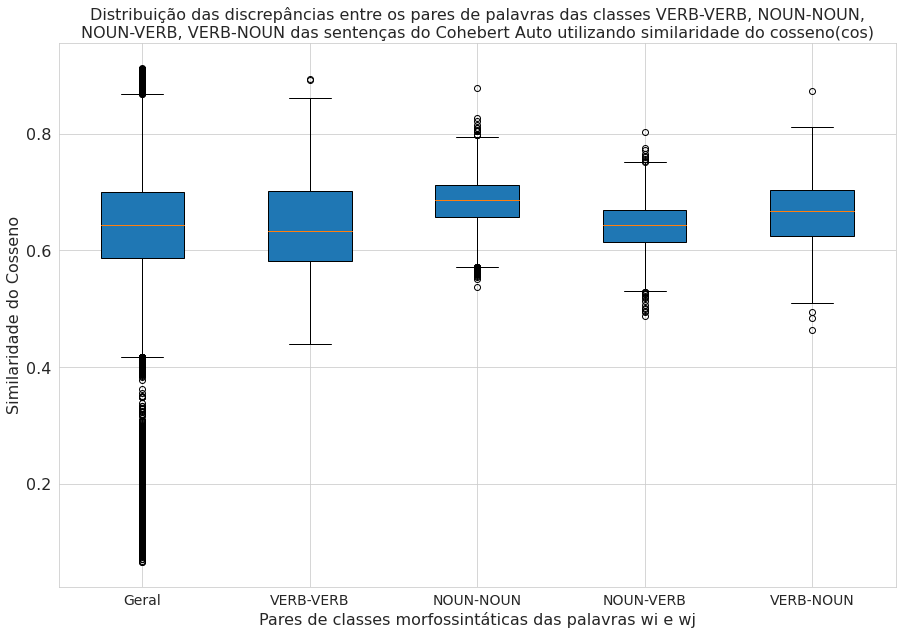

In [216]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_palavra[["cos_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_mean"]].dropna(),
           lista_comparacao_classesNV[["cos_mean"]].dropna(),
           lista_comparacao_classesVN[["cos_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### EUC

In [217]:
df_all = pd.concat([lista_comparacao_palavra[["euc_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_mean"]].dropna(),
                    lista_comparacao_classesNV[["euc_mean"]].dropna(),
                    lista_comparacao_classesVN[["euc_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,euc_mean,euc_mean,euc_mean,euc_mean,euc_mean
count,113120.000000,557.000000,5334.000000,1694.000000,4180.000000
mean,33.715206,35.338459,32.651760,35.476540,34.453673
std,5.041517,5.605693,3.083509,3.248292,3.746339
min,14.579185,16.538916,21.830118,25.232309,17.615896
25%,30.571531,31.624149,30.671366,32.814011,32.238837
50%,33.405199,34.179043,32.384041,35.062521,34.517769
75%,36.936570,39.886223,34.566113,37.175776,36.740705
max,62.703007,50.514065,50.884773,50.321831,53.409966


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


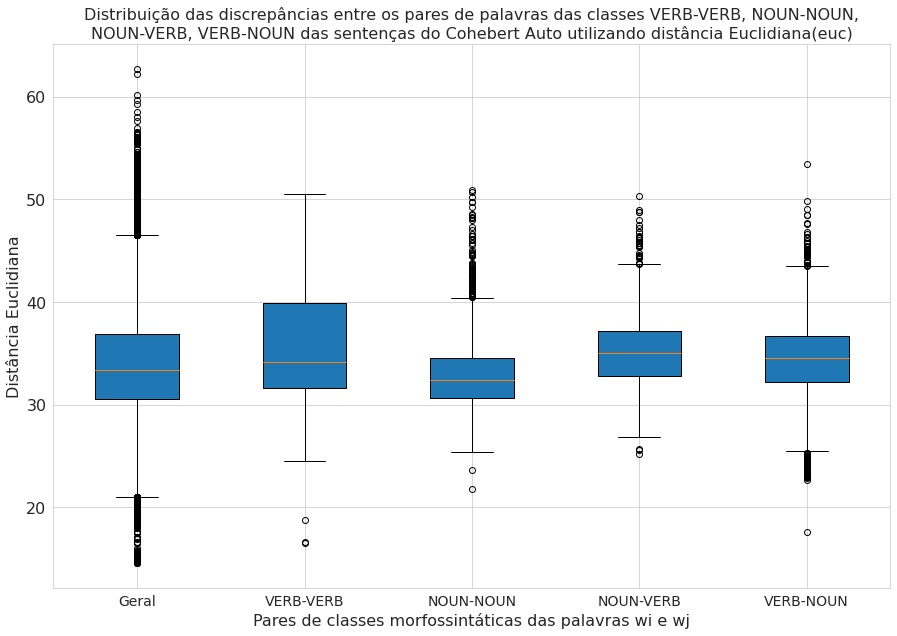

In [218]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_palavra[["euc_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_mean"]].dropna(),
           lista_comparacao_classesNV[["euc_mean"]].dropna(),
           lista_comparacao_classesVN[["euc_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### MAN

In [219]:
df_all = pd.concat([lista_comparacao_palavra[["man_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_mean"]].dropna(),
                    lista_comparacao_classesNV[["man_mean"]].dropna(),
                    lista_comparacao_classesVN[["man_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,man_mean,man_mean,man_mean,man_mean,man_mean
count,113120.000000,557.000000,5334.000000,1694.000000,4180.000000
mean,1614.663405,1639.554132,1535.045660,1663.431292,1630.570087
std,207.151986,224.165686,124.514397,128.869193,170.837330
min,695.769400,809.813400,1095.268800,1192.729900,849.933960
25%,1483.302500,1481.414800,1450.633600,1558.424300,1525.799600
50%,1624.030050,1593.469700,1528.178350,1646.896100,1633.397500
75%,1754.387950,1822.128200,1625.862850,1751.572100,1744.950575
max,2326.535600,2157.011700,2087.149200,2128.584500,2174.617200


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


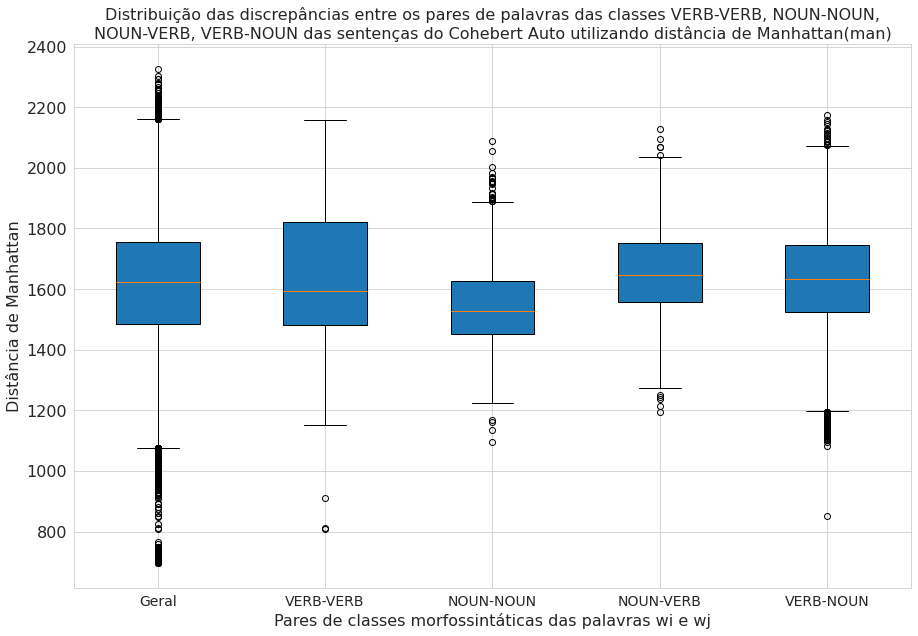

In [220]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_palavra[["man_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_mean"]].dropna(),
           lista_comparacao_classesNV[["man_mean"]].dropna(),
           lista_comparacao_classesVN[["man_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

## 3.6 Ocorrências de pares de palavras

### Indexa os dados das comparações pelo id do documento

In [221]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id"])
lista_comparacao_palavra_indexado.head()

,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
id,,,,,,,,,,,,,,
1p0,0,0,0,Como,SCONJ,1,enfileirar,VERB,0.761694,25.747267,1281.734600,0.663389,32.028095,1584.620800
1p0,0,0,0,Como,SCONJ,2,elementos,NOUN,0.617482,35.318653,1718.498000,0.617482,35.318653,1718.498000
1p0,0,0,0,Como,SCONJ,3,em,ADP,0.650087,33.424171,1681.771700,0.650087,33.424171,1681.771700
1p0,0,0,0,Como,SCONJ,4,uma,DET,0.704987,29.126415,1443.124000,0.704987,29.126415,1443.124000
1p0,0,0,0,Como,SCONJ,5,pilha,NOUN,0.603006,34.711918,1627.421800,0.603006,34.711918,1627.421800


### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [222]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos'

# Estratégia medida
estrategia_medida = 'mean'

# Palavra a ser procurada
palavra_chave = "pilha"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]

          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1

          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9                                                    
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)
media = soma_medida / conta
print("Média medida", (medida + "_" + estrategia_medida), " : ", media)

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

Número de comparações com  pilha  :  6997
Média medida cos_mean  :  0.5996543670021773


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [223]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[4] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") " + linha2[2] + "(" + linha2[3] + ")"

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/2020 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de pares de palavras com similaridade acima do threshold

In [224]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):

  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold
1 pilha(NOUN) ?(PUNCT) 711
2 pilha(NOUN) uma(DET) 710
3 pilha(NOUN) elementos(NOUN) 405
4 pilha(NOUN) em(ADP) 405
5 pilha(NOUN) e(CCONJ) 349
6 pilha(NOUN) é(AUX) 291
7 pilha(NOUN) como(ADV) 259
8 pilha(NOUN) enfileirar(VERB) 206
9 pilha(NOUN) elemento(NOUN) 204
10 pilha(NOUN) de(SCONJ) 202
11 pilha(NOUN) O(PRON) 182
12 pilha(NOUN) Como(ADV) 153
13 pilha(NOUN) Como(SCONJ) 148
14 pilha(NOUN) desenfileirar(ADV) 103
15 pilha(NOUN) um(DET) 103
16 pilha(NOUN) nela(PRON) 103
17 pilha(NOUN) seu(DET) 101
18 pilha(NOUN) seus(DET) 101
19 pilha(NOUN) as(DET) 101
20 pilha(NOUN) operações(NOUN) 101


### 3.6.2 Raio de proximidade

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [225]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Palavra a ser procurada
palavra_chave = "pilha"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1

          # Calcula a distância da chaves 
          distancia = abs(linha['index_wj'] - linha['index_wi'])
            
          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1
          
          # Calcula a distância da chaves 
          distancia = abs(linha['index_wi'] - linha['index_wj'])
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

Número de comparações com  pilha  :  6997


#### 3.6.2.2 Seleciona comparações entre palavras que esteja a um determinado raio ao redor da palavra chave

In [226]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
raio = 2

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do raio
        if linha2[4] <= raio:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") - " + str(linha2[4]) + " - " + linha2[2] + "(" + linha2[3] + ")"
            
            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/2020 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista ordenada das 20 maiores ocorrências de pares de palavras até o raio

In [227]:
top = 20

print("Lista ordenada das", top, "maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das 20 maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio
1 pilha(NOUN) - 1 - uma(DET) 710
2 pilha(NOUN) - 1 - e(CCONJ) 305
3 pilha(NOUN) - 2 - é(AUX) 305
4 pilha(NOUN) - 1 - ?(PUNCT) 304
5 pilha(NOUN) - 2 - em(ADP) 304
6 pilha(NOUN) - 2 - como(ADV) 266
7 pilha(NOUN) - 1 - a(DET) 101
8 pilha(NOUN) - 2 - operação(NOUN) 101
9 pilha(NOUN) - 2 - Em(ADP) 101
10 pilha(NOUN) - 2 - como(SCONJ) 37
11 pilha(NOUN) - 2 - como(ADP) 2


# 4 Finalização

## 4.1 Tempo final de processamento



In [228]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:02:17 (h:mm:ss)
